# Explaining Models

Predictive models have different properties. Some are designed to handle linear data. Others can modl to more complex input. Some models can be interpreted very easily, others are like black boxes and don't offer much insight into how the prediction is made. 

In this section we'll look at interpreting different models:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [3]:
X_train = pd.read_csv('data/titanic_X_train.csv')
X_test = pd.read_csv('data/titanic_X_test.csv')
y_train = pd.read_csv('data/titanic_y_train.csv')['survived']
y_test = pd.read_csv('data/titanic_y_test.csv')['survived']
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [4]:
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

## Regression Coefficients

The intercepts and regression coefficients explain the expected value, and how features impact the prediction. A positive coefficient indicates that as a feature's value increases, the prediction increases as well. 

## Feature Importance

Tree-based models in the scikit-learn library include a `.feature_importances_` attribute for inspecting how the features of a dataset affect the model. We can inspect or plot them.

## LIME

LIME works to help explain black-box models. It performs as local interpretation rather than an overall interpretation. IT will help explalin a single sample. 

For a given data point or sample, LIME indicates which features were important in determining the result. It does this b perturbing the sample in question and fitting a linear model to it. The linear model approximates the model close to the sample.

In [5]:
from lime import lime_tabular

In [6]:
explainer = lime_tabular.LimeTabularExplainer(X_train.values,
                                             feature_names = X_train.columns,
                                             class_names = ["died","survived"])

In [7]:
exp = explainer.explain_instance(X_train.iloc[-1].values, dt.predict_proba)

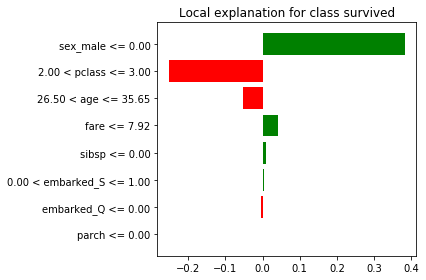

In [8]:
fig = exp.as_pyplot_figure()
fig.tight_layout()

## Tree Interpretation

From sklearn tree-based models you can use the treeinterpreter package. This assists with calculating bias and the contribution from each feature. The bias is th emean of the training set. 

Each contribution lists how it contributes to each of the labels. The bias plus the contributions should sum to the prediction. Since this is a binary classification there are only two. 

In [9]:
from sklearn.ensemble import RandomForestClassifier
rf5 = RandomForestClassifier(**{
    "max_features" : "auto",
    "min_samples_leaf" : 0.1,
    "n_estimators" : 200,
    "random_state" : 42,
})

rf5.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [10]:
from treeinterpreter import treeinterpreter as ti

In [11]:
instances = X.iloc[:2]
prediction, bias, contribs = ti.predict(rf5, instances)

In [12]:
i = 0
print("Instance", i)
print("Prediction", prediction[i])
print("Bias", bias[i])
print("Feature contributions:")
for c, feature in zip(contribs[i], instances.columns):
    print(f" {feature} {c}")

Instance 0
Prediction [0.82046191 0.17953809]
Bias [0.63887555 0.36112445]
Feature contributions:
 pclass [ 0.02865085 -0.02865085]
 age [ 0.01115629 -0.01115629]
 sibsp [ 0.00528926 -0.00528926]
 parch [ 0.00656872 -0.00656872]
 fare [ 0.04126856 -0.04126856]
 sex_male [ 0.07660626 -0.07660626]
 embarked_Q [0. 0.]
 embarked_S [ 0.01204643 -0.01204643]


## Partial Dependence Plots

With feature importance in trees we know that a feature is impacting the outcome, but we don't know how the impact varies as the feature's value changes. Partial dependence plots allow us to visualize the relation between changes in just one feature and the outcome.

Partial dependence plots pin down a feature value across the samples and then average the results. Therefore, we must be careful about outliers and means. This plot assumes features are independent.

We will use pdpbox to visualize how age affects survival. 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


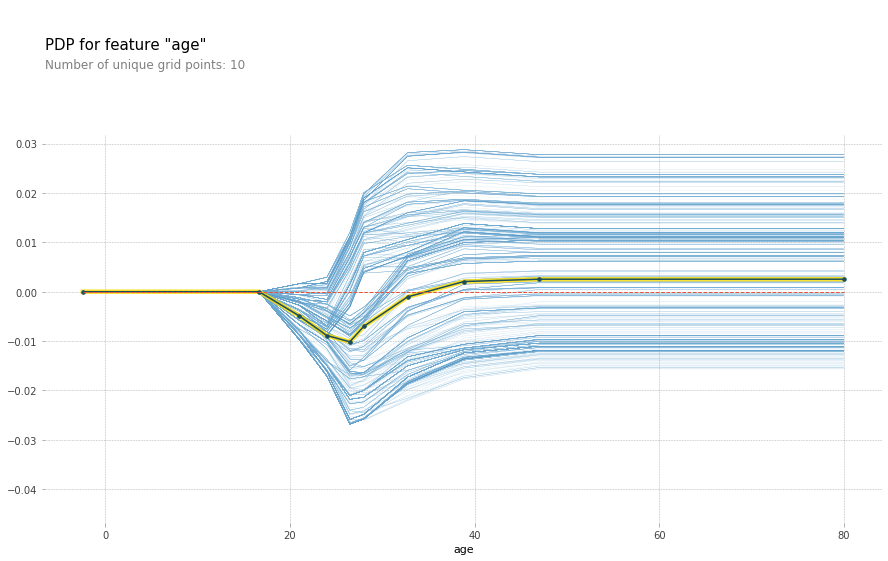

In [13]:
from pdpbox import pdp
feat_name = "age"
p = pdp.pdp_isolate(rf5, X, X.columns, feat_name)
fig, _ = pdp.pdp_plot(p, feat_name, plot_lines=True)

We can also visualize the interactions between two features.

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

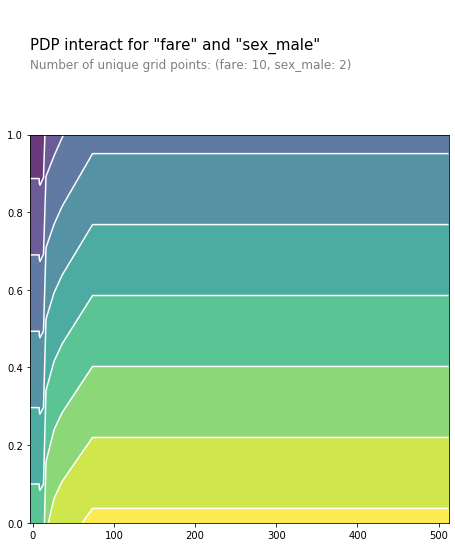

In [14]:
features = ["fare","sex_male"]
p = pdp.pdp_interact(rf5, X, X.columns, features)
fig, _ = pdp.pdp_interact_plot(p, features)

## Surrogate Models

If you have a model that is not interpretable (SVM or neural network), you can fit an interpretable model (decision tree) to that model. Using the surrogate you can examine the feature importances. 

Here we create a SVC, but train a decision tree (without a depth limit to overfit and capture what is happening in this model to explain it.

In [15]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
sur_dt = DecisionTreeClassifier()
sur_dt.fit(X_test, svc.predict(X_test)) # Note here!

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [16]:
for col, val in sorted(zip(X_test.columns, sur_dt.feature_importances_),
                      key = lambda x:x[1],
                      reverse=True)[:7]:
    print(f"{col:10}{val:10.3f}")

fare           0.539
age            0.310
sex_male       0.044
pclass         0.038
sibsp          0.036
embarked_S     0.023
parch          0.011


## Shapley 

The sHapley Additive exPlanations The SHAP package can visualize feature contributions of any model. 

SHAP works on both classification and regression. it generates "SHAP" values. For classification models, the SHAP value sums to log odds for binary classification. For regression, the SHAP values sum to the target prediction.

Here is an example:

In [18]:
rf5.predict_proba(X_test.iloc[[20]])

array([[0.60129761, 0.39870239]])

In the force plot for sample 20, you can see the "base value." 

In [19]:
import shap
shap.initjs()
s = shap.TreeExplainer(rf5)
shap_vals = s.shap_values(X_test)
target_idx = 1
shap.force_plot(s.expected_value[target_idx],
               shap_vals[target_idx][20,:],
               feature_names=X_test.columns)

In [20]:
shap.force_plot(s.expected_value[1],shap_vals[1],feature_names=X_test.columns)

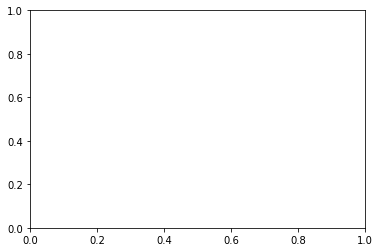

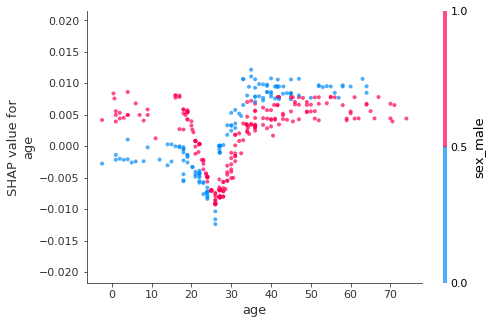

In [21]:
fig, ax = plt.subplots(figsize=(6,4))
res = shap.dependence_plot("age",
                          shap_vals[target_idx],
                          X_test, feature_names=X_test.columns,
                          alpha=0.7)

In addition, we can summarize all of the features. This is a very poweful chart to understand. It shows global impact, but also individual impacts. The features are ranked by importance. The most important features are at the top.

Also the features are colored according to their value.

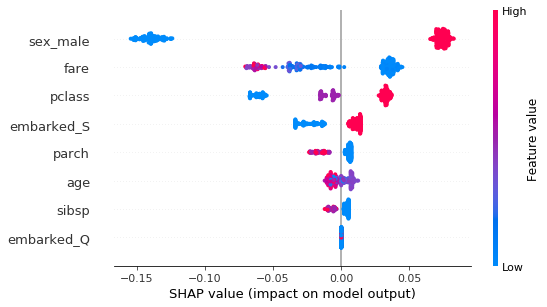

In [37]:
fig, ax = plt.subplots(figsize=(6,4))
shap.summary_plot(shap_vals[0],X_test)